### Fade Margin (FM) Section — Calibrate on OOF, Validate on Test

This notebook calibrates fade margins (FM) for multiple model families (BLR, MLR, POLY2) using Out-Of-Fold (OOF) residuals and validates them on the held-out test residuals.

#### Core & Data Libraries

In [3]:
# Core & Data Libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

#  ML & Stats 
from sklearn.mixture import GaussianMixture
import scipy.stats as sps 

#  Parallel 
from joblib import Parallel, delayed

# SPEED HEADER
import os
# Stop BLAS from oversubscribing; we parallelize with joblib instead
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["NUMEXPR_MAX_THREADS"] = "1"

# Joblib process temp in RAM if available (faster on Linux)
if os.path.isdir("/dev/shm"):
    os.environ.setdefault("JOBLIB_TEMP_FOLDER", "/dev/shm/joblib")

# Parallelism knob for bootstraps 
N_JOBS = -1  # use all available cores
#  Global Toggles 
# Reproducibility / method toggles
EXACT_BCA        = False   # True => exact BCa (jackknife; slower). False => fast BC (no jackknife).
BLOCK_BY_DEVICE  = True    # MBB applied within each device cluster

RANDOM_STATE     = 42

# Targets and baseline
P_GRID           = [0.05, 0.02, 0.01]   # p in {5%, 2%, 1%}
HEURISTIC_FM_DB  = 10.0                 # baseline for comparison

#### Load OOF Residuals

In [4]:
# Data locations
OOF_DIR  = "Data+Files+Plots+etc"
TEST_DIR = "Data+Files+Plots+etc"

# Candidate mappings (OOF) 
CANDIDATE_OOF_FILES = {
    "BLR":   [f"{OOF_DIR}/residuals__BLR__BEST__oof.csv",   f"{OOF_DIR}/residuals_BLR_BEST_oof.csv"],
    "MLR":   [f"{OOF_DIR}/residuals__MLR__BEST__oof.csv",   f"{OOF_DIR}/residuals_MLR_BEST_oof.csv"],
    "POLY2": [f"{OOF_DIR}/residuals__POLY2__BEST__oof.csv", f"{OOF_DIR}/residuals_POLY2_BEST_oof.csv"],
}

# Column detection candidates
TIME_COL_CANDS   = ["timestamp","ts","time","datetime","DateTime","TIME"]
DEVICE_COL_CANDS = ["device","Device","ed","ED","node","Node"]
RESID_COL_CANDS  = ["resid_db", "residuals", "resid", "error", "epsilon"]

def _first_existing(paths):
    for p in paths:
        if os.path.exists(p):
            return p
    raise FileNotFoundError("None of the candidate paths exist:\n  " + "\n  ".join(paths))

def _pick_residual_col(df):
    for c in RESID_COL_CANDS:
        if c in df.columns:
            return c
    raise KeyError("Residual column not found in dataframe.")

def _find_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def _time_sort(df):
    tc = _find_col(df, TIME_COL_CANDS)
    if tc is None:
        return df
    # robust: try native sort; if fails, coerce to datetime
    try:
        return df.sort_values(tc)
    except Exception:
        tmp = pd.to_datetime(df[tc], errors='coerce')
        return df.assign(_t=tmp).sort_values('_t').drop(columns=['_t'])

#  Load OOF (train-side) and matching TEST residuals 
oof_residuals = {}     # fam -> np.array
test_residuals = {}    # fam -> np.array
oof_devices   = {}     # fam -> device array or None
test_devices  = {}     # fam -> device array or None
model_tags    = {}     # fam -> best tag from 'model' column if present

for fam, candidates in CANDIDATE_OOF_FILES.items():
    oof_path = _first_existing(candidates)
    df_oof = _time_sort(pd.read_csv(oof_path))
    res_col = _pick_residual_col(df_oof)
    eps_oof = df_oof[res_col].astype(float).to_numpy()
    oof_residuals[fam] = eps_oof

    # capture device arrays if present
    dev_col_oof = _find_col(df_oof, DEVICE_COL_CANDS)
    oof_devices[fam] = df_oof[dev_col_oof].astype(str).to_numpy() if dev_col_oof else None

    # Prefer specific best tag if present
    specific_tag = None
    if "model" in df_oof.columns and pd.api.types.is_string_dtype(df_oof["model"]):
        try:
            specific_tag = str(df_oof["model"].iloc[0])
        except Exception:
            specific_tag = None
    model_tags[fam] = specific_tag if specific_tag else f"{fam}__BEST"

    # Resolve TEST file; try specific tag first, then family aliases
    test_candidates = []
    if specific_tag:
        test_candidates.append(f"{TEST_DIR}/residuals__{specific_tag}__test.csv")
    test_candidates += [
        f"{TEST_DIR}/residuals__{fam}__BEST__test.csv",
        f"{TEST_DIR}/residuals_{fam}_BEST_test.csv",
    ]
    test_path = _first_existing(test_candidates)
    df_test = _time_sort(pd.read_csv(test_path))
    res_col_test = _pick_residual_col(df_test)
    eps_test = df_test[res_col_test].astype(float).to_numpy()
    test_residuals[fam] = eps_test

    dev_col_test = _find_col(df_test, DEVICE_COL_CANDS)
    test_devices[fam] = df_test[dev_col_test].astype(str).to_numpy() if dev_col_test else None

    print(f"[{fam}] OOF: {oof_path} (n={len(eps_oof)}) | TEST: {test_path} (n={len(eps_test)})")

[BLR] OOF: Data+Files+Plots+etc/residuals__BLR__BEST__oof.csv (n=1663627) | TEST: Data+Files+Plots+etc/residuals__BLR__BEST__test.csv (n=415907)
[MLR] OOF: Data+Files+Plots+etc/residuals__MLR__BEST__oof.csv (n=1663627) | TEST: Data+Files+Plots+etc/residuals__MLR__BEST__test.csv (n=415907)
[POLY2] OOF: Data+Files+Plots+etc/residuals__POLY2__BEST__oof.csv (n=1663627) | TEST: Data+Files+Plots+etc/residuals__POLY2__BEST__test.csv (n=415907)


#### FM Calibration Utilities

In [5]:
# ACF / block length utilities
def acf(x, max_lag=None):
    x = np.asarray(x, float)
    x = x - x.mean()
    n = len(x)
    if n < 3:
        max_lag = 1
    if max_lag is None:
        max_lag = min(200, n - 2) if n > 2 else 1
    c = np.correlate(x, x, mode='full')[n-1:n+max_lag]
    if c[0] == 0:
        return np.arange(max_lag+1), np.ones(max_lag+1)
    return np.arange(max_lag+1), c / c[0]

def choose_block_len_acf(x, alpha=0.05, max_lag=None):
    lags, ac = acf(x, max_lag=max_lag)
    n = len(x)
    if n < 50:
        return 0, {"note": "sample too small; using i.i.d."}
    thr = 1.96 / np.sqrt(n)  # ~95% bounds
    idx = np.where(np.abs(ac[1:]) < thr)[0]
    if len(idx) == 0:
        k = min(len(ac)-1, 25)
    else:
        k = int(idx[0] + 1)
    b = max(5, k)
    return b, {"thr": thr, "first_below_thr_lag": k}

def choose_block_len_acf_cluster(x, clust):
    """Median block length across clusters (skip very small ones)."""
    x = np.asarray(x)
    clust = np.asarray(clust) if clust is not None else None
    if clust is None:
        b, _ = choose_block_len_acf(x)
        return b
    b_list = []
    for g in np.unique(clust):
        idx = (clust == g)
        if idx.sum() < 50:  # insufficient for ACF estimate
            continue
        b_g, _ = choose_block_len_acf(x[idx])
        b_list.append(b_g)
    if not b_list:
        return 0
    return int(np.median(b_list))

def _mbb_draw(x, n, b, rng):
    """Moving-block bootstrap draw of length n from series x with block size b."""
    x = np.asarray(x)
    if b <= 1 or b >= len(x):
        return x[rng.integers(0, len(x), size=n)]
    k = int(np.ceil(n / b))
    starts = rng.integers(0, len(x) - b + 1, size=k)
    return np.concatenate([x[s:s+b] for s in starts])[:n]

def _mbb_draw_by_cluster(x, clust, b, rng):
    """MBB within device clusters; preserves per-device lengths."""
    x = np.asarray(x)
    clust = np.asarray(clust)
    out = []
    for g in np.unique(clust):
        idx = np.where(clust == g)[0]
        xx = x[idx]
        n_g = len(xx)
        out.append(_mbb_draw(xx, n_g, b, rng))
    return np.concatenate(out)

#  quantile utilities 
def normal_cdf(z):
    z = np.asarray(z, dtype=float)
    return sps.norm.cdf(z)

def empirical_quantile(sample, p):
    # FM(p) = Q_{1-p} of residuals
    return float(np.quantile(sample, 1 - p, method='linear'))

def mixture_quantile(weights, means, stds, q, tol=1e-6, max_iter=256):
    means = np.asarray(means); stds = np.asarray(stds)
    stds = np.maximum(stds, 1e-6)  # guard against numeric degeneracy
    lo = float(means.min() - 10*stds.max())
    hi = float(means.max() + 10*stds.max())
    for _ in range(max_iter):
        mid = 0.5*(lo+hi)
        F = float(np.sum(weights * normal_cdf((mid - means)/stds)))
        if F < q: lo = mid
        else:     hi = mid
        if hi - lo < tol: break
    return 0.5*(lo+hi)

#  fixed K=3 mixture fit + tail quantile 
def gmm_fit_quantile(sample, p, n_components=3):
    """
    Fit a 1D GaussianMixture with fixed n_components=3 and return Q_{1-p} of the fitted mixture.
    """
    xs = sample.reshape(-1, 1)
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=RANDOM_STATE)
    gmm.fit(xs)
    w = gmm.weights_
    mu = gmm.means_.ravel()
    cov = gmm.covariances_
    stds = np.sqrt(cov.reshape(-1)) if cov.ndim == 3 else np.sqrt(cov)
    q = mixture_quantile(w, mu, stds, 1 - p)
    aic = float(gmm.aic(xs))
    bic = float(gmm.bic(xs))
    return float(q), {"gmm": gmm, "k": n_components}, aic, bic

#  Nonparametric CIs for empirical quantiles 
def bca_ci(x, stat_fn, alpha=0.05, B=10_000, block_len=0, rng=None, cluster=None):
    """
    Exact BCa CI for statistic stat_fn over sample x.
    Uses MBB if block_len>0; device-aware if cluster provided and BLOCK_BY_DEVICE=True.
    """
    rng = np.random.default_rng(RANDOM_STATE if rng is None else rng)
    x = np.asarray(x)
    n = len(x)
    theta_hat = stat_fn(x)

    # bootstrap replicates (serial to keep jackknife coherent)
    thetas = np.empty(B, dtype=float)
    ss = np.random.SeedSequence(RANDOM_STATE)
    children = ss.spawn(B)
    for b in range(B):
        rr = np.random.default_rng(children[b])
        if block_len > 1:
            if (cluster is not None) and BLOCK_BY_DEVICE:
                xb = _mbb_draw_by_cluster(x, cluster, block_len, rr)
            else:
                xb = _mbb_draw(x, n, block_len, rr)
        else:
            xb = x[rr.integers(0, n, size=n)]
        thetas[b] = stat_fn(xb)
    thetas.sort()

    # bias-correction z0
    z0 = sps.norm.ppf((thetas < theta_hat).mean() + 1e-12)

    # jackknife for acceleration 'a'
    jack = np.empty(n)
    for i in range(n):
        jack[i] = stat_fn(np.delete(x, i))
    jack_mean = jack.mean()
    num = np.sum((jack_mean - jack)**3)
    den = 6.0 * (np.sum((jack_mean - jack)**2) ** 1.5)
    a = (num / den) if den > 0 else 0.0

    zal = sps.norm.ppf(alpha/2); zau = sps.norm.ppf(1 - alpha/2)
    def _adj(z): return sps.norm.cdf(z0 + (z0 + z) / (1 - a*(z0 + z)))
    a1 = float(np.clip(_adj(zal), 0, 1)); a2 = float(np.clip(_adj(zau), 0, 1))

    lo = float(np.quantile(thetas, a1, method='linear'))
    hi = float(np.quantile(thetas, a2, method='linear'))
    return lo, hi, {"theta_hat": float(theta_hat), "z0": float(z0), "a": float(a)}

def _boot_q_once(x, p, b, sseq, cluster=None):
    rr = np.random.default_rng(sseq)
    if b > 1:
        if (cluster is not None) and BLOCK_BY_DEVICE:
            xb = _mbb_draw_by_cluster(x, cluster, b, rr)
        else:
            xb = _mbb_draw(x, len(x), b, rr)
    else:
        xb = x[rr.integers(0, len(x), size=len(x))]
    return float(np.quantile(xb, 1 - p, method='linear'))

def bc_ci_fast(x, p, alpha=0.05, B=3000, block_len=0, n_jobs=N_JOBS, seed=RANDOM_STATE, cluster=None):
    """
    Fast CI for FM(p)=Q_{1-p}:
    - Parallel bootstrap with MBB (b>0); device-aware if cluster provided.
    - Bias-Corrected (BC) via z0 (no jackknife).
    """
    x = np.asarray(x, float)
    theta_hat = float(np.quantile(x, 1 - p, method='linear'))

    ss = np.random.SeedSequence(seed)
    children = ss.spawn(B)

    q_boot = Parallel(n_jobs=n_jobs, backend="loky", max_nbytes="256M", verbose=0)(
        delayed(_boot_q_once)(x, p, block_len, child, cluster) for child in children
    )
    q_boot = np.asarray(q_boot, float)

    if q_boot.min() < theta_hat < q_boot.max():
        prop = (q_boot < theta_hat).mean()
        z0 = float(sps.norm.ppf(min(max(prop, 1e-12), 1 - 1e-12)))
        al = float(sps.norm.cdf(2*z0 + sps.norm.ppf(alpha/2)))
        au = float(sps.norm.cdf(2*z0 + sps.norm.ppf(1 - alpha/2)))
        al = float(np.clip(al, 0.0, 1.0)); au = float(np.clip(au, 0.0, 1.0))
    else:
        al, au = alpha/2, 1 - alpha/2

    lo, hi = np.quantile(q_boot, [al, au], method='linear')
    return float(lo), float(hi), {"theta_hat": theta_hat}

#  Parametric bootstrap CI for GMM-3 tail FM 
def _gmm_sample(n, weights, means, stds, rng):
    k = len(weights)
    comps = rng.choice(k, size=n, p=weights)
    return rng.normal(loc=means[comps], scale=stds[comps], size=n)

def gmm_parametric_ci(sample, p, gmm_obj, alpha=0.05, B=5000, seed=RANDOM_STATE):
    """
    Parametric bootstrap CI for FM(p) under a fitted 1D Gaussian mixture.
    Draws length-n samples from the fitted mixture and re-computes Q_{1-p}.
    """
    n = len(sample)
    rng = np.random.default_rng(seed)
    w = gmm_obj.weights_
    mu = gmm_obj.means_.ravel()
    cov = gmm_obj.covariances_
    stds = np.sqrt(cov.reshape(-1)) if cov.ndim == 3 else np.sqrt(cov)

    theta_hat = mixture_quantile(w, mu, stds, 1 - p)

    qs = np.empty(B, dtype=float)
    for b in range(B):
        xs = _gmm_sample(n, w, mu, stds, rng)
        qs[b] = np.quantile(xs, 1 - p, method='linear')
    lo, hi = np.quantile(qs, [alpha/2, 1 - alpha/2], method='linear')
    return float(lo), float(hi), {"theta_hat_param": float(theta_hat)}

#  Main FM routine (GMM-3 only) 
def fm_with_uncertainty(eps, p, use_parametric=True, B=5000, random_state=RANDOM_STATE, cluster=None, alpha=0.05):
    """
    Returns FM estimates and CIs.

    - Empirical FM always computed (with BCa or BC bootstrap CI).
    - If use_parametric=True, we fit a fixed 3-component GMM to eps, compute its tail FM and
      parametric-bootstrap CIs. For p <= 0.02, we prescribe the conservative maximum of
      the empirical and GMM-3 tail estimates; otherwise we keep the empirical FM.
    - The reported CI always brackets the selected FM: empirical CI for empirical rows,
      parametric CI for mixture rows.
    """
    eps = np.asarray(eps, float)

    # Dependence-aware block length (per cluster if available)
    block_len = choose_block_len_acf_cluster(eps, cluster)

    # Empirical quantile + CI
    if EXACT_BCA:
        lo_e, hi_e, info = bca_ci(
            eps,
            stat_fn=lambda v: float(np.quantile(v, 1 - p, method='linear')),
            alpha=alpha, B=B, block_len=block_len, rng=random_state, cluster=cluster
        )
        fm_emp = float(np.quantile(eps, 1 - p, method='linear'))
        note_emp = "empirical quantile (BCa)"
    else:
        lo_e, hi_e, info = bc_ci_fast(
            eps, p, alpha=alpha, B=B, block_len=block_len, n_jobs=N_JOBS, seed=random_state, cluster=cluster
        )
        fm_emp = info["theta_hat"]
        note_emp = "empirical quantile (BC bootstrap)"

    out = {
        "p": p, "block_len": block_len,
        "fm_emp": fm_emp, "fm_emp_lo": lo_e, "fm_emp_hi": hi_e,
        "param_name": None, "fm_param": np.nan, "param_lo": np.nan, "param_hi": np.nan,
        "param_aic": np.nan, "param_bic": np.nan,
        "selected": "empirical", "fm_sel": fm_emp, "fm_sel_lo": lo_e, "fm_sel_hi": hi_e,
        "estimator_note": note_emp
    }

    if use_parametric:
        fm_g, gmm_best, aic_g, bic_g = gmm_fit_quantile(eps, p, n_components=3)
        gmm_obj = gmm_best["gmm"]

        # Parametric-bootstrap CI around the mixture tail FM
        lo_p, hi_p, _ = gmm_parametric_ci(eps, p, gmm_obj, alpha=alpha, B=B, seed=random_state)

        out.update({
            "param_name": "gmm(K=3)",
            "fm_param": float(fm_g),
            "param_lo": float(lo_p), "param_hi": float(hi_p),
            "param_aic": float(aic_g), "param_bic": float(bic_g)
        })

        # Conservative switch at far tail if GMM-3 is larger than empirical
        if p <= 0.02 and (fm_g > fm_emp):
            out.update({
                "selected": "gmm-tail",
                "fm_sel": float(fm_g),
                "fm_sel_lo": float(lo_p), "fm_sel_hi": float(hi_p),
                "estimator_note": "gmm tail (K=3; parametric bootstrap CI)"
            })

    return out

#### Calibrate on OOF + Load Test Residuals

In [6]:
rows = []
for fam, eps in oof_residuals.items():
    for p in P_GRID:
        out = fm_with_uncertainty(eps, p, use_parametric=True, B=5000,
                                  random_state=RANDOM_STATE, cluster=oof_devices.get(fam))
        rows.append({"model": fam, **out})

fm_table = pd.DataFrame(rows)

display_cols = [
    "model", "p",
    "fm_emp", "fm_emp_lo", "fm_emp_hi",
    "param_name", "fm_param", "param_lo", "param_hi", "param_aic", "param_bic",
    "selected", "fm_sel", "fm_sel_lo", "fm_sel_hi",
    "block_len", "estimator_note"
]

display(fm_table[display_cols].round(3).sort_values(["model","p"]))

,model,p,fm_emp,fm_emp_lo,fm_emp_hi,param_name,fm_param,param_lo,param_hi,param_aic,param_bic,selected,fm_sel,fm_sel_lo,fm_sel_hi,block_len,estimator_note
2,BLR,0.01,27.793,27.401,28.130,gmm(K=3),27.670,27.557,27.789,1.147949e+07,1.147959e+07,empirical,27.793,27.401,28.130,25,empirical quantile (BC bootstrap)
1,BLR,0.02,19.571,19.463,19.667,gmm(K=3),21.857,21.758,21.956,1.147949e+07,1.147959e+07,gmm-tail,21.857,21.758,21.956,25,gmm tail (K=3; parametric bootstrap CI)
0,BLR,0.05,13.179,13.121,13.236,gmm(K=3),13.195,13.145,13.244,1.147949e+07,1.147959e+07,empirical,13.179,13.121,13.236,25,empirical quantile (BC bootstrap)
5,MLR,0.01,28.049,27.648,28.442,gmm(K=3),28.048,27.919,28.175,1.147045e+07,1.147055e+07,empirical,28.049,27.648,28.442,25,empirical quantile (BC bootstrap)
4,MLR,0.02,19.469,19.361,19.578,gmm(K=3),21.593,21.482,21.705,1.147045e+07,1.147055e+07,gmm-tail,21.593,21.482,21.705,25,gmm tail (K=3; parametric bootstrap CI)
3,MLR,0.05,12.990,12.934,13.049,gmm(K=3),12.753,12.708,12.797,1.147045e+07,1.147055e+07,empirical,12.990,12.934,13.049,25,empirical quantile (BC bootstrap)
8,POLY2,0.01,24.052,23.878,24.207,gmm(K=3),25.731,25.607,25.855,1.102616e+07,1.102626e+07,gmm-tail,25.731,25.607,25.855,25,gmm tail (K=3; parametric bootstrap CI)
7,POLY2,0.02,18.156,18.043,18.259,gmm(K=3),19.655,19.550,19.761,1.102616e+07,1.102626e+07,gmm-tail,19.655,19.550,19.761,25,gmm tail (K=3; parametric bootstrap CI)
6,POLY2,0.05,11.957,11.892,12.014,gmm(K=3),11.496,11.455,11.537,1.102616e+07,1.102626e+07,empirical,11.957,11.892,12.014,25,empirical quantile (BC bootstrap)


#### Held‑Out Validation (Test) for all three models

In [7]:
def achieved_outage_rate(eps_test, FM):
    return float(np.mean(eps_test > FM))

validation_rows = []
for fam, eps_test in test_residuals.items():
    sub = fm_table[fm_table["model"] == fam]
    for _, r in sub.iterrows():
        FM = r["fm_sel"]; p = r["p"]
        phat = achieved_outage_rate(eps_test, FM)
        validation_rows.append({
            "model": fam, "p_target": p,
            "FM_used": FM, "FM_lo": r["fm_sel_lo"], "FM_hi": r["fm_sel_hi"],
            "achieved_outage": phat, "achieved_PDR": 1.0 - phat,
            "estimator": r["selected"]
        })
    # Heuristic baseline
    ph = achieved_outage_rate(eps_test, HEURISTIC_FM_DB)
    validation_rows.append({
        "model": fam, "p_target": None,
        "FM_used": HEURISTIC_FM_DB, "FM_lo": np.nan, "FM_hi": np.nan,
        "achieved_outage": ph, "achieved_PDR": 1.0 - ph,
        "estimator": f"Heuristic ({HEURISTIC_FM_DB} dB)"
    })

validation_df = pd.DataFrame(validation_rows)

display(validation_df.sort_values(["model","p_target"], na_position='last').round(4))

,model,p_target,FM_used,FM_lo,FM_hi,achieved_outage,achieved_PDR,estimator
2,BLR,0.01,27.7933,27.4012,28.1295,0.0134,0.9866,empirical
1,BLR,0.02,21.8573,21.7575,21.9557,0.0190,0.9810,gmm-tail
0,BLR,0.05,13.1785,13.1215,13.2363,0.0435,0.9565,empirical
3,BLR,NaN,10.0000,NaN,NaN,0.0773,0.9227,Heuristic (10.0 dB)
6,MLR,0.01,28.0490,27.6482,28.4418,0.0135,0.9865,empirical
5,MLR,0.02,21.5925,21.4823,21.7047,0.0199,0.9801,gmm-tail
4,MLR,0.05,12.9904,12.9337,13.0486,0.0441,0.9559,empirical
7,MLR,NaN,10.0000,NaN,NaN,0.0763,0.9237,Heuristic (10.0 dB)
10,POLY2,0.01,25.7306,25.6073,25.8549,0.0144,0.9856,gmm-tail
9,POLY2,0.02,19.6546,19.5496,19.7611,0.0207,0.9793,gmm-tail


#### Plot: PDR vs FM — overlay for BLR / MLR / POLY2

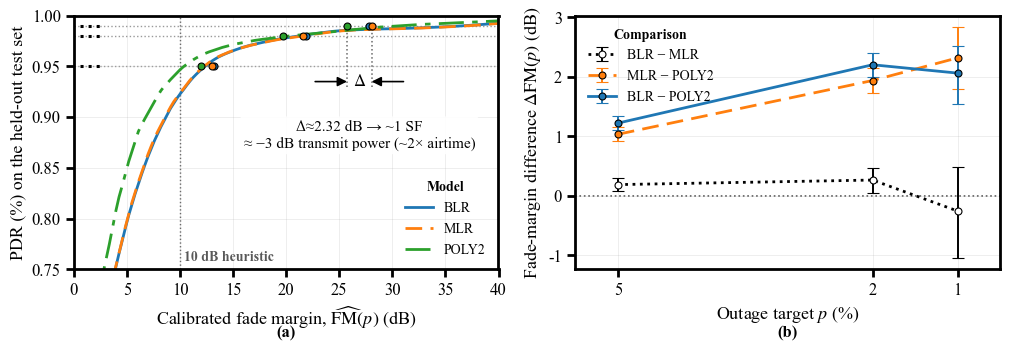

In [15]:
# Plot of the two key analyses combined into one figure:
# (a) Held-out PDR vs fade margin (FM) + calibrated points/CI + Δ callout
# (b) ΔFM comparisons with 95% CI (BLR−MLR first, then each of them vs POLY2)

HEURISTIC_FM_DB = float(globals().get("HEURISTIC_FM_DB", 10.0))
SHOW_HEURISTIC_VLINE_A = True

legend_map = {"MLR":   "MLR", "BLR":   "BLR", "POLY2": "POLY2",}

style_map = {"BLR":   dict(ls="-",  dashes=None), "MLR":   dict(ls="--", dashes=(6, 3)), "POLY2": dict(ls="-.", dashes=(9, 3, 2, 3)),
}
ORDER = ["BLR", "MLR", "POLY2"]

def p_as_dec(p):
    p = float(p)
    return p/100.0 if p > 1.0 else p

P_GRID_DEC = sorted([p_as_dec(p) for p in P_GRID], reverse=True)

# normalize fm_table p as decimals too
fm = fm_table.copy()
fm["p_dec"] = fm["p"].astype(float)
fm.loc[fm["p_dec"] > 1.0, "p_dec"] = fm.loc[fm["p_dec"] > 1.0, "p_dec"] / 100.0

def pdr_curve(eps_test, fm_min=0.0, fm_max=None, num=160):
    eps = np.asarray(eps_test, float)
    if fm_max is None:
        fm_max = np.percentile(eps, 99.9)
    grid = np.linspace(fm_min, fm_max, num=num)
    pdr  = np.array([np.mean(eps <= m) for m in grid], float)
    return grid, pdr

def row_for(model, p_dec):
    mask = (fm["model"] == model) & np.isclose(fm["p_dec"].to_numpy(), p_dec)
    r = fm[mask]
    if r.empty:
        return None
    return {
        "fm": float(r["fm_sel"].iloc[0]),
        "lo": float(r["fm_sel_lo"].iloc[0]),
        "hi": float(r["fm_sel_hi"].iloc[0]),
    }

# shared x-range for panel (a)
eps_all = [np.asarray(v, float) for v in test_residuals.values()]
shared_fm_max = max(float(HEURISTIC_FM_DB), *[float(np.percentile(eps, 99.9)) for eps in eps_all])

# empirical curves on test residuals
curves = {}
for fam, eps_test in test_residuals.items():
    fm_grid, pdr_grid = pdr_curve(eps_test, fm_min=0.0, fm_max=shared_fm_max, num=160)
    curves[fam] = {"fm_grid": fm_grid, "pdr_grid": pdr_grid}

fig, (axA, axB) = plt.subplots(1, 2, figsize=(10.2, 3.6))
fig.subplots_adjust(bottom=0.18, wspace=0.28)

# Panel (a): PDR vs FM
line_handles = {}
for fam in ORDER:
    if fam not in curves:
        continue
    st = style_map.get(fam, {})
    ln, = axA.plot(curves[fam]["fm_grid"], curves[fam]["pdr_grid"], linewidth=2, linestyle=st.get("ls", "-"), label=legend_map.get(fam, fam),  zorder=2 )
    if st.get("dashes") is not None:
        ln.set_dashes(st["dashes"])
    line_handles[fam] = ln

# iso-lines + dotted caps for visibility
ISO_CAP_X0, ISO_CAP_X1 = 0.6, 2.6
for p_dec in P_GRID_DEC:
    y = 1.0 - p_dec
    axA.axhline(y, linestyle=":", linewidth=1.0, color="0.6", zorder=0.8)
    axA.plot([ISO_CAP_X0, ISO_CAP_X1], [y, y], linestyle=":", linewidth=2.2, color="black", solid_capstyle="round", zorder=3)

# 10 dB heuristic reference
if SHOW_HEURISTIC_VLINE_A:
    axA.axvline(HEURISTIC_FM_DB, linestyle=":", linewidth=1.0, color="0.35", zorder=1)
    axA.text(HEURISTIC_FM_DB + 0.4, 0.755, f"{HEURISTIC_FM_DB:.0f} dB heuristic", fontsize=10, fontweight="bold", color="0.35", ha="left", va="bottom", clip_on=True)

# calibrated markers + 95% CI bars
for fam in ORDER:
    sub = fm[fm["model"] == fam]
    for p_dec in P_GRID_DEC:
        r = sub[np.isclose(sub["p_dec"].to_numpy(), p_dec)]
        if r.empty:
            continue

        fm_p = float(r["fm_sel"].iloc[0])
        y    = 1.0 - p_dec

        c = line_handles[fam].get_color() if fam in line_handles else None
        axA.plot([fm_p], [y], marker="o", markersize=5, linestyle="None", markerfacecolor=c, markeredgecolor="black", markeredgewidth=0.8, zorder=5)

        lo = float(r["fm_sel_lo"].iloc[0])
        hi = float(r["fm_sel_hi"].iloc[0])
        if np.isfinite(lo) and np.isfinite(hi):
            axA.hlines(y, lo, hi, linewidth=2, alpha=0.7, color=c, zorder=4)

# Δ callout at p=1%: POLY2 vs MLR
p_callout = 0.01
y_target  = 1.0 - p_callout

row_poly = row_for("POLY2", p_callout)
row_mlr  = row_for("MLR",   p_callout)

if (row_poly is not None) and (row_mlr is not None):
    x_poly = row_poly["fm"]
    x_mlr  = row_mlr["fm"]

    x_lo, x_hi = (x_poly, x_mlr) if x_poly <= x_mlr else (x_mlr, x_poly)
    delta = x_hi - x_lo
    x_mid = 0.5 * (x_lo + x_hi)

    ymin, ymax = 0.75, 1.0
    span = ymax - ymin

    BRACKET_DROP_FRAC   = 0.24
    CURVE_CLEAR_FRAC    = 0.06
    INSIDE_MARGIN_FRAC  = 0.08

    y_bracket = y_target - BRACKET_DROP_FRAC * span

    ys_mid = []
    for fam in ORDER:
        if fam in curves:
            ys_mid.append(np.interp(x_mid, curves[fam]["fm_grid"], curves[fam]["pdr_grid"]))
    if ys_mid:
        y_curve_min = float(np.min(ys_mid))
        y_bracket = min(y_bracket, y_curve_min - CURVE_CLEAR_FRAC * span)

    y_bracket = float(np.clip( y_bracket, ymin + INSIDE_MARGIN_FRAC * span, ymax - INSIDE_MARGIN_FRAC * span
    ))

    # vertical guides from the target iso-line down to the Δ annotation level
    axA.vlines([x_lo, x_hi], y_bracket, y_target, colors="0.35", linestyles=":", linewidth=1.1, alpha=0.9, zorder=2)

    # arrows + Δ share the same y-level
    y_arrow = y_bracket + 0.02 * span  # small lift to align with the Δ symbol

    dx_arrow = 3.0
    x0 = max(0.0, x_lo - dx_arrow)
    x1 = min(40.0, x_hi + dx_arrow)

    arrow_kw = dict(arrowstyle="-|>", lw=1.2, color="black", mutation_scale=14, shrinkA=0, shrinkB=0)

    axA.annotate("", xy=(x_lo, y_arrow), xytext=(x0, y_arrow), arrowprops=arrow_kw, zorder=8)
    axA.annotate("", xy=(x_hi, y_arrow), xytext=(x1, y_arrow), arrowprops=arrow_kw, zorder=8)

    axA.text(x_mid, y_arrow, r"$\Delta$", ha="center", va="center", fontsize=12, fontweight="bold", zorder=9)

    # label centered between the two FM points
    axA.annotate(
        f"Δ≈{delta:.2f} dB → ~1 SF\n≈ −3 dB transmit power (~2× airtime)",
        xy=(x_mid, y_bracket),
        xytext=(0, -24),
        textcoords="offset points",
        ha="center", va="top", fontsize=11,
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="none", alpha=0.90),
        zorder=9
    )

axA.set_xlabel(r"Calibrated fade margin, $\widehat{\mathrm{FM}}(p)$ (dB)", fontsize=13)
axA.set_ylabel("PDR (%) on the held-out test set", fontsize=13)
axA.set_xlim(0.0, 40)
axA.set_ylim(0.75, 1.0)
axA.tick_params(axis="both", labelsize=12)
axA.grid(True, which="both", linewidth=0.5, alpha=0.3, zorder=0)

axA.legend(
    title="Model",
    loc="lower right",
    title_fontproperties={"weight": "bold"},
    frameon=False
)

axA.text(0.5, -0.22, "(a)", transform=axA.transAxes, ha="center", va="top", fontsize=12, fontweight="bold")

# Panel (b): ΔFM comparisons vs p (%)
comparisons = [("BLR",  "MLR",   "BLR − MLR"), ("MLR",  "POLY2", "MLR − POLY2"), ("BLR",  "POLY2", "BLR − POLY2"),]

for A, B, label in comparisons:
    xs, ds, err_lo, err_hi = [], [], [], []

    for p_dec in P_GRID_DEC:
        rA = row_for(A, p_dec)
        rB = row_for(B, p_dec)
        if (rA is None) or (rB is None):
            continue

        d    = rA["fm"] - rB["fm"]
        d_lo = rA["lo"] - rB["hi"]
        d_hi = rA["hi"] - rB["lo"]

        xs.append(p_dec * 100.0)
        ds.append(d)
        err_lo.append(max(d - d_lo, 0.0))
        err_hi.append(max(d_hi - d, 0.0))

    if not xs:
        continue

    if (A, B) == ("BLR", "MLR"):
        c = "black"
        ls = ":"
        mfc = "white"
        mec = "black"
        dashes = None
    else:
        c  = line_handles[A].get_color() if A in line_handles else None
        st = style_map.get(A, {})
        ls = st.get("ls", "-")
        dashes = st.get("dashes", None)
        mfc = c
        mec = "black"

    eb = axB.errorbar( xs, ds, yerr=[err_lo, err_hi], marker="o", markersize=5, markerfacecolor=mfc, markeredgecolor=mec, markeredgewidth=0.8,
        linewidth=2,
        linestyle=ls,
        elinewidth=1.4,
        capsize=4,
        capthick=1.4,
        color=c,
        label=label,
        zorder=3
    )
    if dashes is not None:
        try:
            eb.lines[0].set_dashes(dashes)
        except Exception:
            pass

axB.axhline(0.0, linestyle=":", linewidth=1.2, color="0.35", zorder=1)

xt = [p * 100.0 for p in P_GRID_DEC]
axB.set_xticks(xt)
axB.set_xlim(max(xt) + 0.5, min(xt) - 0.5)

axB.set_xlabel("Outage target $p$ (%)", fontsize=13)
axB.set_ylabel("Fade-margin difference $\\Delta\\mathrm{FM}(p)$ (dB)", fontsize=13)
axB.tick_params(axis="both", labelsize=12)
axB.grid(True, which="both", linewidth=0.5, alpha=0.3, zorder=0)

axB.legend( title="Comparison", loc="upper left", title_fontproperties={"weight": "bold"}, frameon=False)

axB.text(0.5, -0.22, "(b)", transform=axB.transAxes, ha="center", va="top", fontsize=12, fontweight="bold")

# frame
for ax in (axA, axB):
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(2)
        spine.set_edgecolor("black")
    ax.tick_params(which="both", width=2, length=6)

plt.tight_layout()
plt.savefig("Data+Files+Plots+etc/pdr_fm_with_delta_savings.png", dpi=2000)
plt.show()

#### Display Summaries + Paper Snippet

In [9]:
# Dispaly tables
display(fm_table)
display(validation_df)

def paper_snippet(model_name, p=0.01):
    sub = fm_table[(fm_table["model"] == model_name) & (fm_table["p"] == p)]
    if sub.empty:
        return f"[{model_name}] No FM row for p={p}."
    sub = sub.iloc[0]
    val = validation_df[(validation_df["model"] == model_name) & (validation_df["p_target"] == p)]
    if val.empty:
        return f"[{model_name}] No validation row for p={p}."
    val = val.iloc[0]
    fm = sub["fm_sel"]; lo = sub["fm_sel_lo"]; hi = sub["fm_sel_hi"]; est = sub["selected"]
    ach_p = val["achieved_outage"]; ach_pdr = val["achieved_PDR"]
    return (
        f"FM calibration for {model_name}: For p={p:.2%}, we obtain FM{int((1-p)*100)} = {fm:.2f} dB "
        f"[95% CI: {lo:.2f}, {hi:.2f}] using {est}. On held-out test, achieved outage "
        f"is {ach_p:.2%} (PDR={ach_pdr:.2%})."
    )

for fam in ["BLR", "MLR", "POLY2"]:
    if fam in fm_table["model"].unique():
        print(paper_snippet(fam, p=0.01))

,model,p,block_len,fm_emp,fm_emp_lo,fm_emp_hi,param_name,fm_param,param_lo,param_hi,param_aic,param_bic,selected,fm_sel,fm_sel_lo,fm_sel_hi,estimator_note
0,BLR,0.05,25,13.178512,13.121469,13.236278,gmm(K=3),13.195252,13.145006,13.244301,1.147949e+07,1.147959e+07,empirical,13.178512,13.121469,13.236278,empirical quantile (BC bootstrap)
1,BLR,0.02,25,19.570908,19.463179,19.666811,gmm(K=3),21.857258,21.757522,21.955694,1.147949e+07,1.147959e+07,gmm-tail,21.857258,21.757522,21.955694,gmm tail (K=3; parametric bootstrap CI)
2,BLR,0.01,25,27.793258,27.401168,28.129541,gmm(K=3),27.670005,27.556766,27.788802,1.147949e+07,1.147959e+07,empirical,27.793258,27.401168,28.129541,empirical quantile (BC bootstrap)
3,MLR,0.05,25,12.990381,12.933680,13.048577,gmm(K=3),12.752794,12.707722,12.796911,1.147045e+07,1.147055e+07,empirical,12.990381,12.933680,13.048577,empirical quantile (BC bootstrap)
4,MLR,0.02,25,19.468632,19.360884,19.578037,gmm(K=3),21.592548,21.482310,21.704700,1.147045e+07,1.147055e+07,gmm-tail,21.592548,21.482310,21.704700,gmm tail (K=3; parametric bootstrap CI)
5,MLR,0.01,25,28.049032,27.648227,28.441781,gmm(K=3),28.047654,27.919082,28.175488,1.147045e+07,1.147055e+07,empirical,28.049032,27.648227,28.441781,empirical quantile (BC bootstrap)
6,POLY2,0.05,25,11.956940,11.892028,12.014198,gmm(K=3),11.495694,11.454531,11.537330,1.102616e+07,1.102626e+07,empirical,11.956940,11.892028,12.014198,empirical quantile (BC bootstrap)
7,POLY2,0.02,25,18.155629,18.043042,18.259450,gmm(K=3),19.654559,19.549585,19.761115,1.102616e+07,1.102626e+07,gmm-tail,19.654559,19.549585,19.761115,gmm tail (K=3; parametric bootstrap CI)
8,POLY2,0.01,25,24.051563,23.878180,24.206513,gmm(K=3),25.730588,25.607306,25.854912,1.102616e+07,1.102626e+07,gmm-tail,25.730588,25.607306,25.854912,gmm tail (K=3; parametric bootstrap CI)


,model,p_target,FM_used,FM_lo,FM_hi,achieved_outage,achieved_PDR,estimator
0,BLR,0.05,13.178512,13.121469,13.236278,0.043488,0.956512,empirical
1,BLR,0.02,21.857258,21.757522,21.955694,0.018961,0.981039,gmm-tail
2,BLR,0.01,27.793258,27.401168,28.129541,0.013385,0.986615,empirical
3,BLR,NaN,10.000000,NaN,NaN,0.077253,0.922747,Heuristic (10.0 dB)
4,MLR,0.05,12.990381,12.933680,13.048577,0.044149,0.955851,empirical
5,MLR,0.02,21.592548,21.482310,21.704700,0.019891,0.980109,gmm-tail
6,MLR,0.01,28.049032,27.648227,28.441781,0.013474,0.986526,empirical
7,MLR,NaN,10.000000,NaN,NaN,0.076279,0.923721,Heuristic (10.0 dB)
8,POLY2,0.05,11.956940,11.892028,12.014198,0.039196,0.960804,empirical
9,POLY2,0.02,19.654559,19.549585,19.761115,0.020726,0.979274,gmm-tail


FM calibration for BLR: For p=1.00%, we obtain FM99 = 27.79 dB [95% CI: 27.40, 28.13] using empirical. On held-out test, achieved outage is 1.34% (PDR=98.66%).
FM calibration for MLR: For p=1.00%, we obtain FM99 = 28.05 dB [95% CI: 27.65, 28.44] using empirical. On held-out test, achieved outage is 1.35% (PDR=98.65%).
FM calibration for POLY2: For p=1.00%, we obtain FM99 = 25.73 dB [95% CI: 25.61, 25.85] using gmm-tail. On held-out test, achieved outage is 1.44% (PDR=98.56%).
